In [23]:
%%capture
from transformers import pipeline
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
import ast
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import default_timer as timer
task = "zero-shot-classification"
# see there: https://huggingface.co/typeform/distilbert-base-uncased-mnli
model = "typeform/distilbert-base-uncased-mnli"
classifier = pipeline(task, model, device=0)
n = 100000

In [5]:
df = pd.read_csv('/home/zemour/old/labelled-quotes-2020.bz2', compression='bz2')
#  Already labelled quotes by the what.ipynb pipeline

In [6]:
import numpy as np

labels = ["joy","sad", "anger", "fear", "neutral", "calm"] # Emotions taken from the Russel model of emotions
m=len(labels)
start = timer()
df['emotion'] = df['quotation'].map(lambda x: classifier(x, labels)['labels'][0:3])
end = timer()
print('Done classifying {:d} quotes with {:d} labels after {:.3f} seconds.'.format(n, m, end - start))

df.to_csv('/home/zemour/old/emotion-quotes-2020.bz2', compression='bz2')


/home/zemour/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:908: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Done classifying 100000 quotes with 6 labels after 598.550 seconds.


In [7]:
df.head(10)

,Unnamed: 0,quotation,qids,date,topic,emotion
0,876460,We want the money out to people as soon as pos...,"['Q106942', 'Q2936261']",2020-04-07 00:00:00,"['world', 'business', 'economy']","[anger, sad, calm]"
1,3104112,From an equity lens there is something inheren...,"['Q16107228', 'Q18378925']",2020-03-10 19:47:00,"['politics', 'world', 'economy']","[sad, fear, anger]"
2,1924991,Americans want to see their president out fron...,['Q7804031'],2020-03-24 14:43:22,"['U.S.', 'politics', 'economy']","[anger, fear, sad]"
3,831979,[ It ] has taken American attention away from ...,['Q5232425'],2020-03-03 05:14:55,"['politics', 'business', 'U.S.']","[sad, anger, fear]"
4,2575214,This was my second year as an advisor in the a...,['Q5040552'],2020-01-30 20:23:04,"['business', 'economy', 'culture']","[calm, joy, neutral]"
5,1801163,They have been providing these resettlement se...,"['Q21931953', 'Q672774']",2020-01-08 00:00:00,"['U.S.', 'world', 'culture']","[calm, sad, joy]"
6,1928020,"When I was 17, a hurricane destroyed my town I...","['Q43390357', 'Q43914913', 'Q56556511']",2020-03-13 00:32:50,"['U.S.', 'economy', 'world']","[calm, anger, sad]"
7,547425,Nash believes Mamaragan won't have a problem w...,"['Q1459540', 'Q1701929', 'Q18756912', 'Q195586...",2020-03-31 02:49:39,"['culture', 'world', 'economy']","[calm, neutral, joy]"
8,1838196,What we need is an experienced hand on the til...,['Q24034267'],2020-01-08 11:22:09,"['politics', 'culture', 'world']","[calm, neutral, anger]"
9,1175467,"The girl, Pratibha, came under the van as a do...","['Q23416653', 'Q42287918']",2020-02-08 12:52:24,"['politics', 'culture', 'technology']","[sad, fear, calm]"


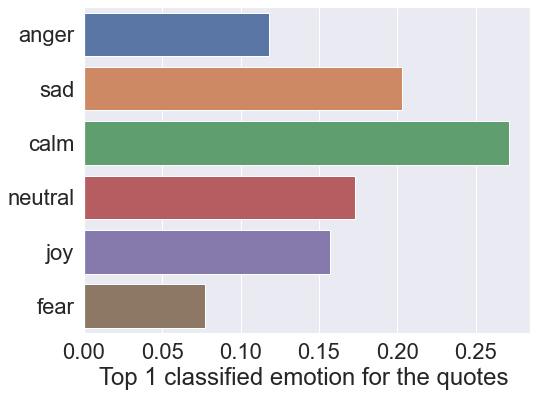

In [29]:
##  Small analysis of the emotions detected in the dataset
# First load the dataset 
df = pd.read_csv('./emotion-quotes-2020.bz2')
quotes=  df['quotation']
emotions = list(df["emotion"])
# Then computes the proportion of each emotion in the dataset 
emotions=  Counter([ast.literal_eval(x)[0] for x in emotions ])
emotions = {k:v/n for k,v in dict(emotions).items()}
sns.set(font_scale=2)
keys = list(emotions.keys())
vals = list(emotions.values())
plt.figure(figsize=(8,6))
sns.barplot(x=vals, y=keys)
plt.xlabel('Top 1 classified emotion for the quotes [1]')
plt.show()
# Mostly calm quotes, which is expected from journalistic quotes

From Fig.1 we can see that the classifier mostly detected calm quotes followed by sad and neutral quotes, which is expected from journalistic quotes which are either in a descriptive tone, or in a sad tone to convey emotion to the reader.

100%|██████████| 100000/100000 [00:43<00:00, 2307.36it/s]


{'Positive quotes': 0.43222, 'Neutral quotes': 0.4099, 'Negative quotes': 0.15786}


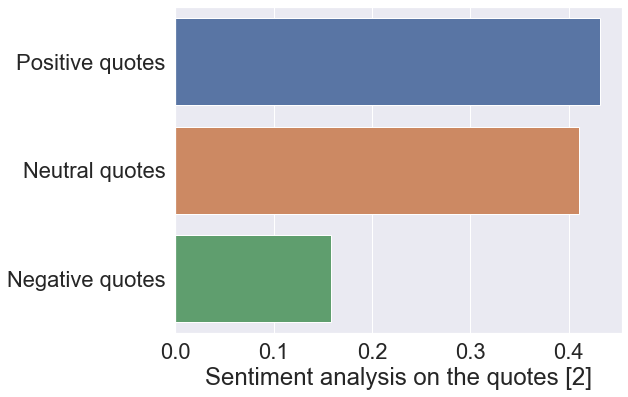

In [31]:
# Sentiment analysis using VADER
df = pd.read_csv('./emotion-quotes-2020.bz2')
quotes=  df['quotation']
analyzer = SentimentIntensityAnalyzer() # initialize the Vader sentiment analyzer
classified = []
for i in tqdm(range(len(quotes))):
    classified.append((quotes[i],analyzer.polarity_scores(quotes[i]))) # Classifying all the quotes 
threshold = 0.3 # Threshold for defining which quotes will be emotional and which will be neutral
                # To precise using the labels acquiered in the Hugging Face zero-shot approach 
positive = len([1 for a,b in classified if b['compound']>threshold])
negative = len([1 for a,b in classified if b['compound']<-threshold])
neutral = len([1 for a,b in classified if -threshold<b['compound']<threshold])
sentiments = {"Positive quotes" : positive/n, "Neutral quotes" : neutral/n, "Negative quotes" : negative/n}
print(sentiments)
sns.set(font_scale=2)
keys = list(sentiments.keys())
vals = list(sentiments.values())
plt.figure(figsize=(8,6))
sns.barplot(x=vals, y=keys)
plt.xlabel('Sentiment analysis on the quotes [2]')
plt.show()

The result obtained in Fig.2 are congruent with those displayed in Fig.1 and obtained through emotion classification. Indeed, calm quotes will be redirected to positive and neutral quotes, therefore explaining the abundance of positive quotes regarding to negative ones. 